# 1. FC model

In [0]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


In [0]:
data = pd.read_csv("AAPL_data.csv")

In [0]:
def preprocess(raw_close_prices, days_per_chunk = 30):
    # normalize input
    raw_close_prices = np.array(raw_close_prices)
    raw_max = np.max(raw_close_prices)
    raw_min  = np.min(raw_close_prices)
    raw_close_prices = (raw_close_prices - raw_min) / (raw_max - raw_min)

    # Use sliding window to get all training dataset
    lst_of_lst = []
    end = 0
    beg = 0
    window = []

    while(end < len(raw_close_prices)):
        window.append(raw_close_prices[end])
        if len(window) == days_per_chunk:
            lst_of_lst.append(window.copy())
            window.remove(raw_close_prices[beg])
            beg += 1
        end += 1

    # x are prices before last day 
    x = [d[0:days_per_chunk-1] for d in lst_of_lst]
    # y is the price of the last dat
    y = [d[days_per_chunk-1] for d in lst_of_lst]
    
    return np.asarray(x),np.asarray(y)

In [0]:
close_prices = data['close'].to_list()

In [5]:
DAYS_PER_CHUNK = 30
x, y = preprocess(close_prices, DAYS_PER_CHUNK)
print('x shape: ' + str(x.shape) + '\ny shape: ' + str(y.shape))

x shape: (1230, 29)
y shape: (1230,)


In [0]:
def split_train_test_dataset(x_orig, y_orig, train_test_ratio = 0.8):
    orig_size = len(x_orig)
    train_size = math.floor(orig_size * (train_test_ratio))
    test_size = orig_size - train_size
    
    x_train = x_orig[0:train_size]
    x_test = x_orig[train_size:]
    
    y_train = y_orig[0:train_size]
    y_test = y_orig[train_size:]
    
    return x_train, x_test, y_train, y_test

In [7]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = split_train_test_dataset(x, y, 0.8)
print('x_train_orig shape: ' + str(x_train_orig.shape) + '\nx_test_orig shape: ' + str(x_test_orig.shape))
print('y_train_orig shape: ' + str(y_train_orig.shape) + '\ny_test_orig shape: ' + str(y_test_orig.shape))

x_train_orig shape: (984, 29)
x_test_orig shape: (246, 29)
y_train_orig shape: (984,)
y_test_orig shape: (246,)


In [0]:
def reshape(train_x_orig, train_y_orig, test_x_orig, test_y_orig):
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

    train_x = torch.Tensor(train_x_flatten).cuda()
    test_x = torch.Tensor(test_x_flatten).cuda()
    train_y = torch.Tensor(train_y_orig).cuda()
    test_y = torch.Tensor(test_y_orig).cuda()

    return train_x, train_y, test_x, test_y

In [9]:
train_x, train_y, test_x, test_y = reshape(x_train_orig, y_train_orig, x_test_orig, y_test_orig)
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: torch.Size([984, 29])
test_x's shape: torch.Size([246, 29])
train_y's shape: torch.Size([984])
test_y's shape: torch.Size([246])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([984])) that is different to the input size (torch.Size([984, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 100, Loss:0.55630
Epoch: 200, Loss:0.46804
Epoch: 300, Loss:0.38705
Epoch: 400, Loss:0.30669
Epoch: 500, Loss:0.23035
Epoch: 600, Loss:0.16787
Epoch: 700, Loss:0.11939
Epoch: 800, Loss:0.08567
Epoch: 900, Loss:0.06601
Epoch: 1000, Loss:0.05683


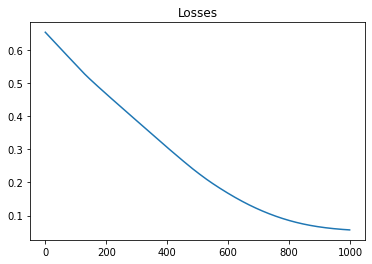

In [10]:
EPOCHS = 1000
LR = 0.0001

model_fc = nn.Sequential(
    nn.Linear(DAYS_PER_CHUNK-1, 7),
    nn.ReLU(),
    nn.Linear(7, 7),
    nn.ReLU(),
    nn.Linear(7, 7),
    nn.ReLU(),
    nn.Linear(7, 1)
).cuda()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_fc.parameters(), lr=LR)

losses = []
for i in range(EPOCHS):                   
    out = model_fc(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if (i+1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))

plt.title("Losses")
plt.plot(losses)

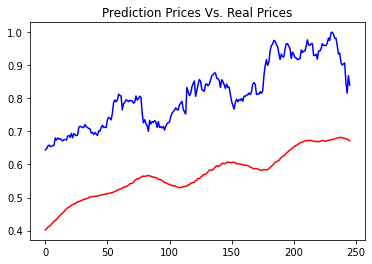

In [11]:
pred_y = model_fc(test_x)
pred_y_cpu = pred_y.cpu()
test_y_cpu = test_y.cpu()
pred_y_np = pred_y_cpu.detach().numpy()
test_y_np = test_y_cpu.detach().numpy()

plt.title("Prediction Prices Vs. Real Prices")
plt.plot(pred_y_np.flatten(), 'r', label='prediction')
plt.plot(test_y_np.flatten(), 'b', label='real')

# 2. LSTM Model

In [12]:
DAYS_PER_CHUNK = 30
close_prices = data['close'].to_list()
x, y = preprocess(close_prices, DAYS_PER_CHUNK)
print('x shape: ' + str(x.shape) + '\ny shape: ' + str(y.shape))

x shape: (1230, 29)
y shape: (1230,)


In [13]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = split_train_test_dataset(x, y, 0.8)
print('x_train_orig shape: ' + str(x_train_orig.shape) + '\nx_test_orig shape: ' + str(x_test_orig.shape))
print('y_train_orig shape: ' + str(y_train_orig.shape) + '\ny_test_orig shape: ' + str(y_test_orig.shape))

x_train_orig shape: (984, 29)
x_test_orig shape: (246, 29)
y_train_orig shape: (984,)
y_test_orig shape: (246,)


In [0]:
def reshape_lstm(train_x_orig, train_y_orig, test_x_orig, test_y_orig):
    train_x = train_x_orig.reshape(-1,1,DAYS_PER_CHUNK - 1)
    test_x = test_x_orig.reshape(-1,1,DAYS_PER_CHUNK - 1)
    train_y = train_y_orig.reshape(-1,1,1)
    test_y = test_y_orig.reshape(-1,1,1)

    train_x = torch.Tensor(train_x).cuda()
    train_y = torch.Tensor(train_y).cuda()
    test_x = torch.Tensor(test_x).cuda()
    test_y = torch.Tensor(test_y).cuda()

    return train_x, train_y, test_x, test_y

In [15]:
train_x, train_y, test_x, test_y = reshape_lstm(x_train_orig, y_train_orig, x_test_orig, y_test_orig)
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: torch.Size([984, 1, 29])
test_x's shape: torch.Size([246, 1, 29])
train_y's shape: torch.Size([984, 1, 1])
test_y's shape: torch.Size([246, 1, 1])


In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, _x):
        x, _ = self.lstm(_x)
        s, b, h = x.shape  
        x = x.view(s*b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  
        return x


Epoch: 100, Loss:0.00303
Epoch: 200, Loss:0.00116
Epoch: 300, Loss:0.00085
Epoch: 400, Loss:0.00072
Epoch: 500, Loss:0.00063
Epoch: 600, Loss:0.00055
Epoch: 700, Loss:0.00049
Epoch: 800, Loss:0.00044
Epoch: 900, Loss:0.00040
Epoch: 1000, Loss:0.00036


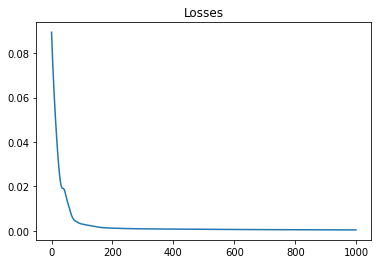

In [17]:
EPOCH = 1000
LR = 0.0008

INPUT_SIZE = DAYS_PER_CHUNK - 1
HIDDEN_SIZE = 12
NUM_LAYERS = 3

model_lstm = LSTM(input_size=INPUT_SIZE, 
                  hidden_size=HIDDEN_SIZE,
                  num_layers=NUM_LAYERS).cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)

losses = []
for i in range(EPOCH):                   
    out = model_lstm(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())
    if (i+1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))

plt.title("Losses")
plt.plot(losses)

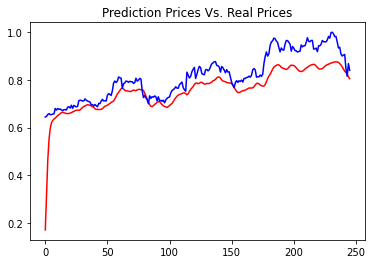

In [18]:
pred_y = model_lstm(test_x)
pred_y_cpu = pred_y.cpu()
test_y_cpu = test_y.cpu()
pred_y_np = pred_y_cpu.detach().numpy()
test_y_np = test_y_cpu.detach().numpy()


plt.title("Prediction Prices Vs. Real Prices")
plt.plot(pred_y_np.flatten(), 'r', label='prediction')
plt.plot(test_y_np.flatten(), 'b', label='real')

## 3. LSTM Model Modified

In [19]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf

Using TensorFlow backend.


In [20]:
# Load the data
df = pd.read_csv('AAPL_data.csv')
df.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
5,2013-02-15,66.9785,67.1656,65.7028,65.7371,97924631,AAPL
6,2013-02-19,65.8714,66.1042,64.8356,65.7128,108854046,AAPL
7,2013-02-20,65.3842,65.3842,64.1142,64.1214,118891367,AAPL
8,2013-02-21,63.7142,64.1671,63.2599,63.7228,111596821,AAPL
9,2013-02-22,64.1785,64.5142,63.7999,64.4014,82583823,AAPL


In [0]:
# Preprocess the data for LSTM

dataset = df['open'].values.reshape(-1, 1)

In [0]:
train_set = dataset[:int(dataset.shape[0] * .8)]
test_set = dataset[int(dataset.shape[0] * .8):]

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [0]:
def create_my_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [0]:
x_train, y_train = create_my_dataset(train_set)
x_test, y_test = create_my_dataset(test_set)

In [0]:
 x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
 x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [28]:
# Peek into the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
957/957 [==============================] - 8s 9ms/step - loss: 0.0415
Epoch 2/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0068
Epoch 3/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0052
Epoch 4/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0045
Epoch 5/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0048
Epoch 6/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0044
Epoch 7/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0042
Epoch 8/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0037
Epoch 9/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0037
Epoch 10/30
957/957 [==============================] - 7s 8ms/step - loss: 0.0037
Epoch 11/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0038
Epoch 12/30
957/957 [==============================] - 7s 7ms/step - loss: 0.0042
Epoch 13/30
957/957 [====

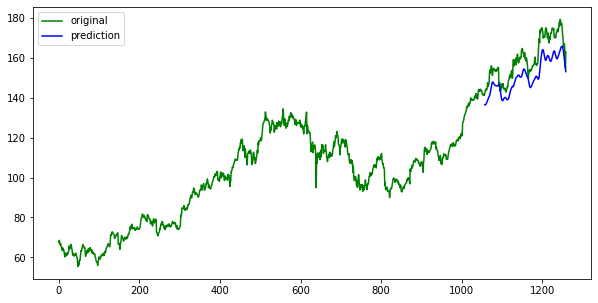

In [30]:
# Visualize the predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(10, 5))
plt.plot(dataset, 'green', label='original')
start = 100 + len(x_train)
end = start + len(x_test)
plt.plot(range(start, end), predictions, 'blue', label = 'prediction')
plt.legend()

Text(0.5, 1.0, 'Performance of predictions')

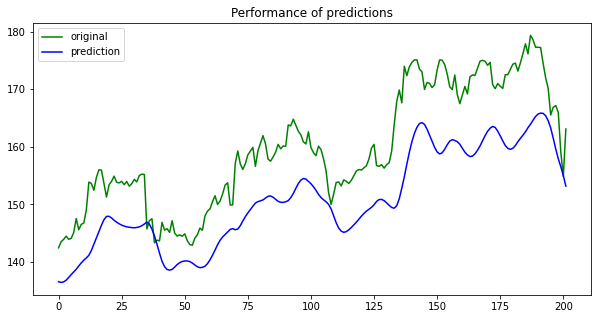

In [31]:
# Now zoom in on the prediction part of the plot

plt.figure(figsize=(10, 5))
y_val = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_val, 'green', label='original')
plt.plot(predictions, 'blue', label = 'prediction')
plt.legend()
plt.title('Performance of predictions')

In [0]:
def mean_squared_error(actual, predicted):
	sum_square_error = 0.0
	for i in range(len(actual)):
		sum_square_error += (actual[i] - predicted[i])**2.0
	mean_square_error = 1.0 / len(actual) * sum_square_error
	return mean_square_error

In [33]:
mean_squared_error(y_val, predictions)

array([89.56846505])

In [0]:
# We can see that the predictions were quite consistent with the original stock price.
# Now let's try different numbers of epochs, and plot the loss respectively.

In [35]:
EPOCHS = np.arange(10, 80, 10)
losses = []
y_predictions = []

y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

for i in range(len(EPOCHS)):
  model = Sequential()
  model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(loss = 'mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=EPOCHS[i], batch_size=32)
  predictions = model.predict(x_test)
  y_predicted = scaler.inverse_transform(predictions)
  loss = mean_squared_error(y_predicted, y_actual)

  losses.append(loss)
  y_predictions.append(y_predicted)

Epoch 1/10
957/957 [==============================] - 8s 8ms/step - loss: 0.0375
Epoch 2/10
957/957 [==============================] - 7s 7ms/step - loss: 0.0057
Epoch 3/10
957/957 [==============================] - 7s 7ms/step - loss: 0.0059
Epoch 4/10
957/957 [==============================] - 7s 7ms/step - loss: 0.0049
Epoch 5/10
957/957 [==============================] - 7s 8ms/step - loss: 0.0044
Epoch 6/10
957/957 [==============================] - 7s 8ms/step - loss: 0.0040
Epoch 7/10
957/957 [==============================] - 7s 8ms/step - loss: 0.0041
Epoch 8/10
957/957 [==============================] - 7s 8ms/step - loss: 0.0048
Epoch 9/10
957/957 [==============================] - 7s 7ms/step - loss: 0.0038
Epoch 10/10
957/957 [==============================] - 7s 7ms/step - loss: 0.0046
Epoch 1/20
957/957 [==============================] - 8s 8ms/step - loss: 0.0331
Epoch 2/20
957/957 [==============================] - 7s 8ms/step - loss: 0.0055
Epoch 3/20
957/957 [=======

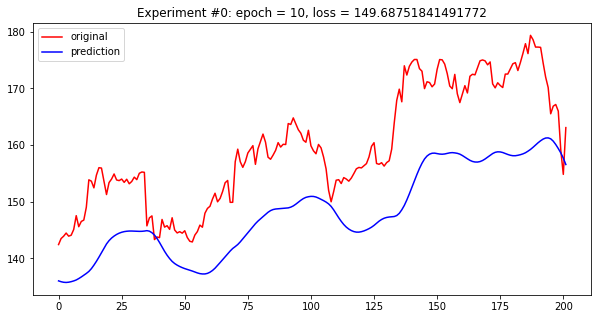

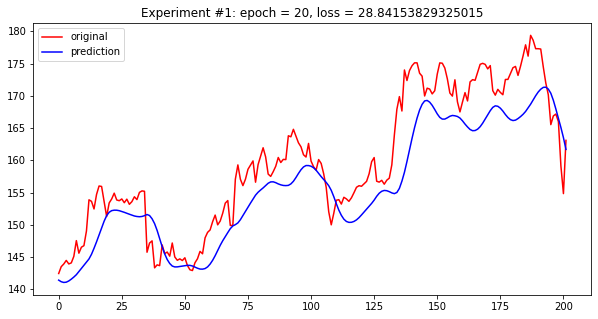

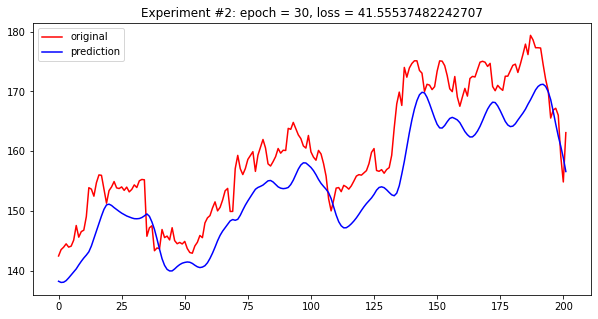

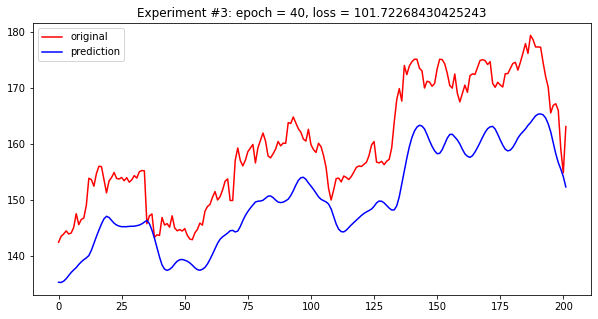

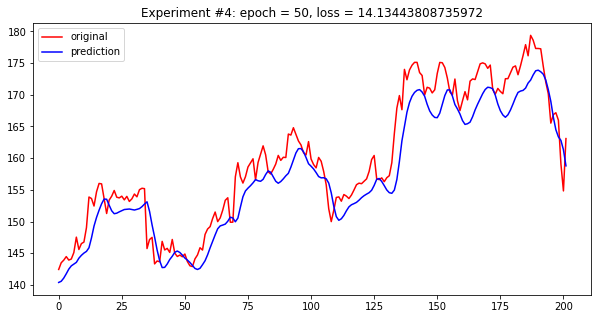

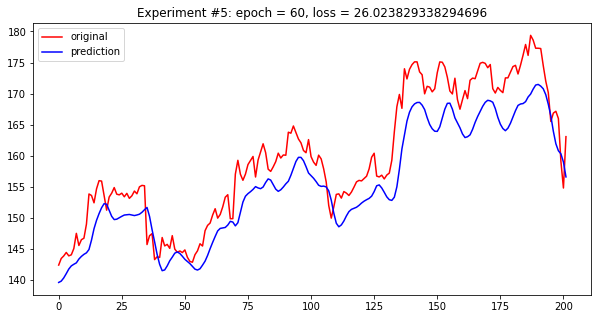

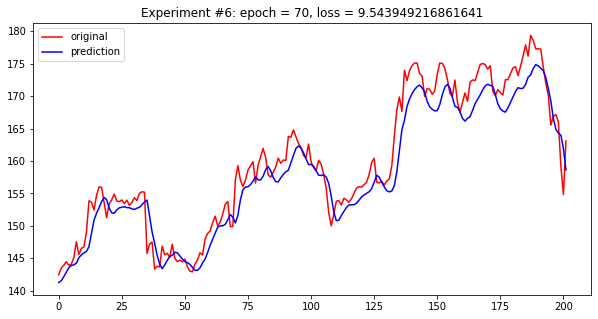

In [36]:
for i in range(len(EPOCHS)):
  y_predicted = y_predictions[i]
  loss = losses[i]
  plt.figure(figsize=(10, 5))
  plt.title('Experiment #' + str(i) + ': epoch = ' + str(EPOCHS[i]) + ', loss = ' + str(loss[0]))
  plt.plot(y_actual, 'red', label='original')
  plt.plot(y_predicted, 'blue', label = 'prediction')
  plt.legend()

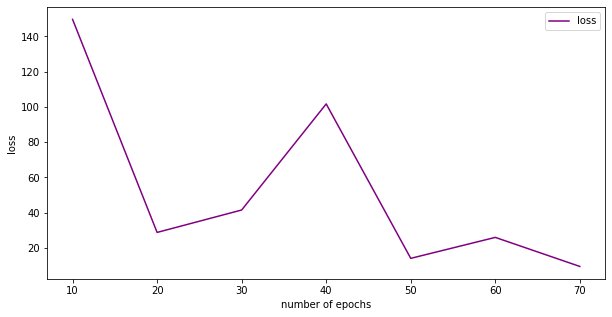

In [37]:
# Plot the losses
plt.figure(figsize=(10,5))
plt.plot(EPOCHS, losses, 'purple', label='loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()

In [0]:
# We can tell that when epochs is around 60, the model gives the best predictions

In [39]:
# Now try to get a more exact result

EPOCHS = np.arange(55, 67, 2)
losses = []
y_predictions = []

y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

for i in range(len(EPOCHS)):
  model = Sequential()
  model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(loss = 'mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=EPOCHS[i], batch_size=32)
  predictions = model.predict(x_test)
  y_predicted = scaler.inverse_transform(predictions)
  loss = mean_squared_error(y_predicted, y_actual)

  losses.append(loss)
  y_predictions.append(y_predicted)

min_loss_index = losses.index(min(losses))
min_loss_epochs = EPOCHS[min_loss_index]
print('The number of epochs should be ' + str(min_loss_epochs))

Epoch 1/55
957/957 [==============================] - 8s 8ms/step - loss: 0.0477
Epoch 2/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0061
Epoch 3/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0052
Epoch 4/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0045
Epoch 5/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0050
Epoch 6/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0043
Epoch 7/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0039
Epoch 8/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0036
Epoch 9/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0036
Epoch 10/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0034
Epoch 11/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0036
Epoch 12/55
957/957 [==============================] - 7s 7ms/step - loss: 0.0032
Epoch 13/55
957/957 [====

Epoch 1/65
957/957 [==============================] - 8s 8ms/step - loss: 0.0472
Epoch 2/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0063
Epoch 3/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0046
Epoch 4/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0044
Epoch 5/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0043
Epoch 6/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0042
Epoch 7/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0049
Epoch 8/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0043
Epoch 9/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0040
Epoch 10/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0044
Epoch 11/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0039
Epoch 12/65
957/957 [==============================] - 7s 7ms/step - loss: 0.0038
Epoch 13/65
957/957 [====

Text(0.5, 1.0, 'Performance of predictions')

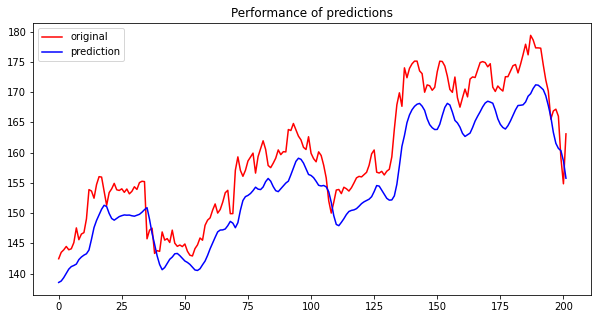

In [40]:
# The final step is to show the best model we've got so far.

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=min_loss_epochs, batch_size=32)


# Then plot the predictions 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
plt.figure(figsize=(10, 5))
y_val = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_val, 'red', label='original')
plt.plot(predictions, 'blue', label = 'prediction')
plt.legend()
plt.title('Performance of predictions')
